In [1]:
from IPython.display import HTML
HTML('''<script> code_show=true;  
function code_toggle() {
 if (code_show){  $('div.input').hide(); 
 } else {  $('div.input').show();  }
 code_show = !code_show
}
$( document ).ready(code_toggle); </script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')



In [2]:
cd -

UsageError: %cd -: No previous directory to change to.

In [3]:
from datetime import datetime, date

In [4]:
from IPython.html.widgets import interact, interactive, fixed

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
from model import *

In [7]:
from cytoolz import sliding_window, count, pipe, thread_first

In [8]:
import seaborn as sns
%matplotlib notebook


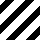
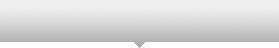
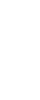
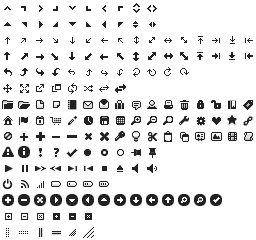
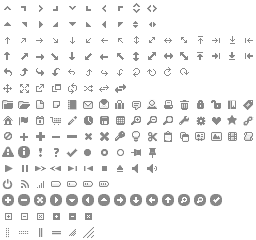
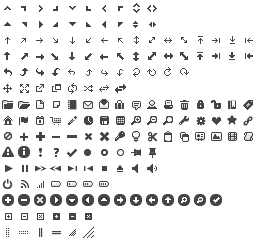
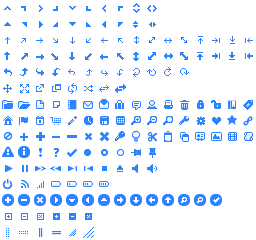
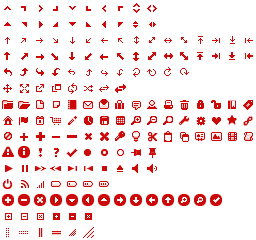
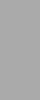
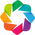
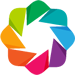
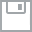
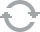
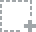
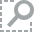
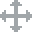
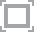
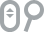

In [9]:
from bokeh.plotting import *
from bokeh.models import TapTool

output_notebook()

### Load risk factors using Blaze

They correspond to
- Deutsche Bank (in USD)
- EURUSD

In [10]:
rf1 = RiskFactor.from_blaze("../../osqf2015/data/db2.bcolz")
rfeurusd = CurrencyRiskFactor.from_blaze("../../osqf2015/data/eurusd.bcolz")

#### Perform the Filtered Historical Simulation

In [11]:
rf1.logreturns()
rf1.devol()
scenarios = rf1.fhs()
df = pd.DataFrame(scenarios, index=rf1.ts.index)

In [12]:
metric = VaR(99)

### Computation functions

In [13]:
def setup_results(df):
    results = pd.DataFrame({'neutral': df.icol(0),
                            'realized': df.shift(-1).icol(0)},
                            index=df.index )
    return results

def quantile_results(results, df, level):
    n_scenarios = len(df.columns) - 1
    results['q_upper'] = df.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=level)
    results['q_lower'] = df.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=100.-level)
    results.eval('shortfall = q_lower - realized')
    results.eval('shortfall_mid = shortfall * 0.5')
    return results

def mark_outliers(df, level):
    is_outlier = df.eval('(q_lower > realized)')
    df.loc[is_outlier,'bad'] = df[is_outlier]['realized']
    is_outlier = df.eval('q_upper < realized')
    df.loc[is_outlier,'good'] = df[is_outlier]['realized']
    
    n_outliers = pd.stats.moments.rolling_count(df.bad, 250)
    df['outliers'] = n_outliers
    m = VaR(level/100.)
    stat = m.likelihood_statistic(n_outliers, 250)
    df['lights'] = VaR.traffic_light(m.confidence(stat))
    return df

In [14]:
def process_full(df, level=99, start='2010-01-01'):
    df_restricted = df[df.index > start]
    return thread_first(df_restricted,
                        setup_results,
                        (quantile_results, df_restricted, level),
                        (mark_outliers, level),
                        lambda x: x.ix[:-2])

### Generation of a ColumnDataSource for a plot

In [15]:
def append_reverse(a, b):
    return np.append(a, np.flipud(b))

def make_envelope_ds(df, coordinates='relative'):
    """ construct data source """
    src = ColumnDataSource()
    d = df.index.tolist()
    src.add(append_reverse(d,d), 'date')
    return src

def update_envelope_ds(df, src, coordinates='relative'):
    """ update data source """
    factor = 0. if coordinates == 'absolute' else df.neutral
    y = append_reverse((df.q_lower - factor).values,
                       (df.q_upper - factor).values)
    src.add(y.tolist(), 'var')
    src.add((df.good - factor).values, 'good')
    src.add((df.bad - factor).values, 'bad')
    src.add((df.realized - factor).values, 'realized')
    return src

def make_outlier_ds(df):
    src = ColumnDataSource()
    src.add( df.index.tolist(), 'date')
    return src

def update_outlier_ds(df, src):
    src.add( df.outliers.values, 'outliers')
    src.add( df.outliers.values * 0.5, 'outliers_mids')
    colors = np.array(['green', 'yellow', 'red'])
    src.add(colors[df.lights.values], 'lights')
    return src


### Plot creation

In [16]:
def make_envelope_plot(src):
    p = figure(title="Backtesting outliers", plot_height=400, plot_width=900, x_axis_type="datetime")
#     p.patch('date', 'var', source=src, color='grey', fill_alpha=0.2)
    p.line('date', 'var', source=src, color='grey', fill_alpha=0.2)
    p.line('date', 'realized', source=src, line_width=1, color='steelblue')
#     p.scatter(x='date', y='good', source=src, size=10, color='green', fill_alpha=0.2, )
    p.scatter(x='date', y='bad', source=src, size=10, color='red', fill_alpha=0.2, )
    return p

In [17]:
def make_outlier_plot(src, range_obj):
    p = figure(plot_height=200, plot_width=900, x_axis_type="datetime", x_range=range_obj)
    w = 20*60*60*1000 # half day in ms
    p.rect(x="date", y='outliers_mids', width=w, height='outliers', color='lights', fill_alpha=0.3, source=src)
    return p

In [18]:
df_res = process_full(df)

In [19]:
ds_envelope = make_envelope_ds(df_res)
ds_envelope = update_envelope_ds(df_res, ds_envelope)

In [20]:
ds_outliers = make_outlier_ds(df_res)
ds_outliers = update_outlier_ds(df_res, ds_outliers)

## Update functions

In [21]:
c = dict(confidence_level=99, l=0.94, src=ds_envelope, src_out=ds_outliers, df=df)

In [22]:
def update_confidence_level(confidence_level=94, cfg=fixed(c)):
    cfg['confidence_level'] = confidence_level
    df_res = process_full(df, level=cfg['confidence_level'])
#     print( df_res.tail())
    ds = update_envelope_ds(df_res, cfg['src'])
    ds_outliers = update_outlier_ds(df_res, cfg['src_out'])
    # propagate changes to plot
    ds.push_notebook()
    ds_outliers.push_notebook()

In [23]:
def update_lambda(_lambda=0.94, cfg=fixed(c)):
    cfg['l'] = 1. - _lambda
    rf1.devol(_lambda=1. - _lambda)
    df = pd.DataFrame(rf1.fhs(), index=rf1.ts.index)
    cfg['df'] = df
    df_res = process_full(df, level=cfg['confidence_level'])
    ds = update_envelope_ds(df_res, cfg['src'])
    ds_outliers = update_outlier_ds(df_res, cfg['src_out'])
    # propagate changes to plot
    ds.push_notebook()
    ds_outliers.push_notebook()

In [24]:
p = make_envelope_plot(ds_envelope)
p2 = make_outlier_plot(ds_outliers, p.x_range)
show(gridplot( [[p],[p2]]))
# show(p)

In [25]:
interact(update_confidence_level, confidence_level=(90, 99, 1));
interact(update_lambda, _lambda=(0.80, 0.99, 0.01));

<IPython.core.display.Javascript object>


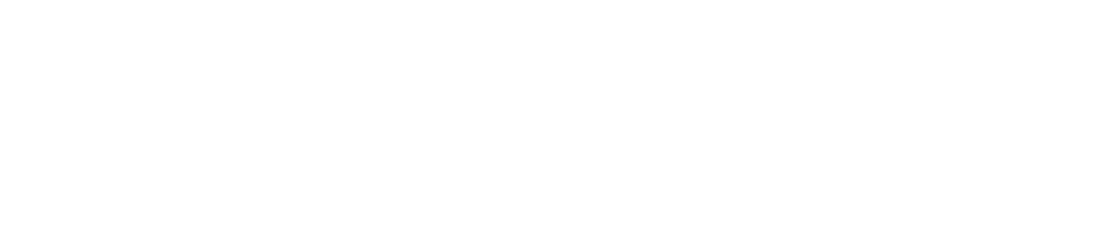

In [26]:
%matplotlib notebook
rf1.ts.Value.loc['01-01-2010':].plot(figsize=(14,3))

<IPython.core.display.Javascript object>


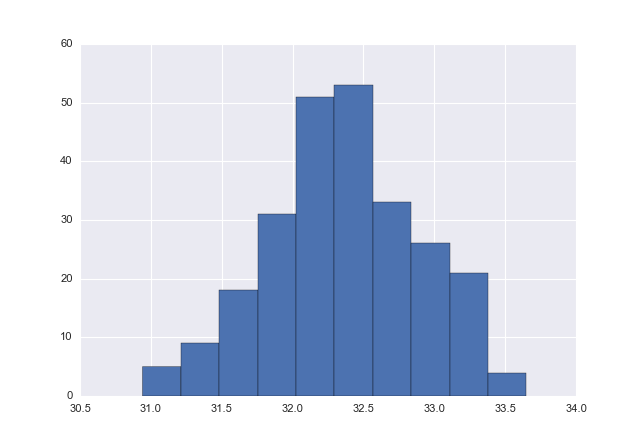

(array([  5.,   9.,  18.,  31.,  51.,  53.,  33.,  26.,  21.,   4.]),
 array([ 30.94119106,  31.21203887,  31.48288668,  31.7537345 ,
         32.02458231,  32.29543013,  32.56627794,  32.83712576,
         33.10797357,  33.37882139,  33.6496692 ]),
 <a list of 10 Patch objects>)

In [27]:
%matplotlib notebook
sns.plt.hist(scenarios[-1,:])

In [42]:
ds_rf = make_rf_ds(rf1)
cfg = dict(l=0.94, src=ds_rf, rf=rf1)

In [65]:
def update_model(_lambda=0.94, cfg=fixed(cfg)):#risk_factor=fixed(rf1), src=fixed(rf_ds)):
    risk_factor = cfg['rf']
    src = cfg['src']
    risk_factor.devol(_lambda=1.-_lambda)
    update_rf_ds(risk_factor, src)
    src.push_notebook()

def make_rf_ds(rf, start='2010-01-01', coordinates='relative'):
    """ construct data source """
    df = rf.ts[start:]
    src = ColumnDataSource(df)
    return src

def update_rf_ds(rf, src, coordinates='relative', start='2010-01-01'):
    """ update data source """
    df = rf.ts[start:]
    src.data['LogReturns'] = df.LogReturns.values
    src.data['DevolLogReturns'] = df.DevolLogReturns.values
    src.data['Vola'] = df.Vola.values
#     src = ColumnDataSource.from_df(df)
    #src.data.update(df[['DevolLogReturns']].to_dict())
    return src

def make_rf_plot(src):
    p = figure(title=None, plot_height=250, plot_width=900, x_axis_type="datetime")
    p.line('Date', 'Vola', source=src, color='orange', fill_alpha=0.2)
    p.line('Date', 'LogReturns', source=src, line_width=1, color='steelblue')
    p.min_border = 0
    p.min_border_top = 10
    p.min_border_bottom =0

    
    p2 = figure(title=None, plot_height=250, plot_width=900, x_axis_type='datetime')
    p2.line('Date', 'DevolLogReturns', source=src, line_width=1, color='green')
    p2.min_border = 0
    p2.min_border_top = 10
    p2.min_border_bottom =0

    return gridplot([[p],[p2]])


In [66]:
p = make_rf_plot(ds_rf)
p.min_border = 0
p.min_border_top = 0
p.min_border_bottom =0
show(p)

In [68]:
w = interact(update_model, _lambda=(0.80, 0.99, 0.01));
w.widget.msg_throttle = 3